In [1]:
# install the packs needed for the script
import os
os.system("pip install pyshark pywavelets matplotlib nest_asyncio")

# os.system("sudo apt-get install tshark")
# os.system("tshark --version")


0

read the data from wireshark

In [ ]:
import pyshark
import numpy as np
import matplotlib.pyplot as plt
import pywt
import nest_asyncio
nest_asyncio.apply()

# Step 1: 解析pcapng文件
import pyshark
import numpy as np


from scipy.interpolate import interp1d

# calculate packet counts
def extract_traffic_features(cap, time_window=0.01):
    
    timestamps = []
    atkflags = []
    
    for packet in cap:
        if 'IP' in packet:  # 只处理包含IP层的包
            timestamps.append(float(packet.sniff_timestamp))
            if 'UDP' in packet:  # 只处理包含UDP层的包
                if hasattr(packet['UDP'], 'payload'):  # 确保存在UDP数据负载
                    udp_payload = packet['UDP'].payload
                    sliced_data = udp_payload[129:131] # atk flag
                    atkflags.append(int(sliced_data, 16))
                    # print("sliced data: ", sliced_data)
                    if sliced_data != '00' and int(sliced_data, 16) > 10:
                        print("related data: ", udp_payload[120:140])
                        # print pack no
                        print("packet no: ", packet.number)
                else:
                    atkflags.append(int('00', 16))
            else:
                atkflags.append(int('00', 16))
    cap.close()
    print("attack flags detected in the pcap file:")
    print(atkflags)


    
    # 转换为流量时间序列
    timestamps = np.array(timestamps)
    relative_time = timestamps - timestamps[0]  # 转换为相对时间
    
    # 计算每个time_window内的包的数量
    num_buckets = int(np.ceil(relative_time[-1] / time_window))  # 计算时间片的数量
    
    # 初始化一个列表用于存储每个时间片内的包数量
    packet_counts = np.zeros(num_buckets, dtype=int)
    
    # 遍历每个包，统计它属于哪个时间片
    for t in relative_time:
        bucket_index = int(t // time_window)  # 计算该包属于哪个时间片
        packet_counts[bucket_index] += 1
    
    # 计算采样率 (每秒钟包的数量)
    total_time_seconds = relative_time[-1]  # 计算总的相对时间
    total_packets = len(relative_time)  # 总的包数量
    sample_rate = total_packets / total_time_seconds  # 采样率: 每秒钟的包数量


    # Macro attack flag
    # if exist not zero attack flag, these packets contain attack
    macro_atkflag = 0
    for i in range(len(atkflags)):
        if atkflags[i] != 0:
            macro_atkflag = atkflags[i]
            break
    
    return relative_time, packet_counts, sample_rate, atkflags, macro_atkflag

# calculate packet size counts
# def extract_traffic_features(pcap_file, time_window=0.01):
#     cap = pyshark.FileCapture(pcap_file)
#     timestamps = []
#     packet_sizes = []
    
#     for packet in cap:
#         if 'IP' in packet:  # 只处理包含IP层的包
#             timestamps.append(float(packet.sniff_timestamp))
#             packet_sizes.append(int(packet.length))  # 获取包的大小
    
#     cap.close()
    
#     # 转换为流量时间序列
#     timestamps = np.array(timestamps)
#     relative_time = timestamps - timestamps[0]  # 转换为相对时间
    
#     # 计算每个time_window内的包的大小总和
#     num_buckets = int(np.ceil(relative_time[-1] / time_window))  # 计算时间片的数量
    
#     # 初始化一个列表用于存储每个时间片内包的大小总和
#     size_sums = np.zeros(num_buckets, dtype=int)
    
#     # 遍历每个包，统计它属于哪个时间片并累加包的大小
#     for t, size in zip(relative_time, packet_sizes):
#         bucket_index = int(t // time_window)  # 计算该包属于哪个时间片
#         size_sums[bucket_index] += size  # 累加包的大小
    
#     # 计算采样率 (每秒钟包的数量)
#     total_time_seconds = relative_time[-1]  # 计算总的相对时间
#     total_packets = len(relative_time)  # 总的包数量
#     sample_rate = total_packets / total_time_seconds  # 采样率: 每秒钟的包数量
    
#     return relative_time, size_sums, sample_rate


# Step 2: 计算连续小波变换 (CWT)
def perform_cwt(time_series, sampling_rate, freq_min, freq_max, wavelet='cmor', scale_num = 200):
    """
    计算连续小波变换 (CWT)，限制频率范围为 [freq_min, freq_max]。

    :param time_series: 输入时间序列
    :param sampling_rate: 时间序列的采样率 (Hz)
    :param freq_min: 分析的最小频率 (Hz)
    :param freq_max: 分析的最大频率 (Hz)
    :param wavelet: 小波基，默认为 'cmor'
    :return: 小波变换系数 (coeffs) 和频率 (freqs)
    """
    sampling_period = 1 / sampling_rate  # 采样周期 (秒)
    
    # 根据频率范围计算尺度范围
    center_frequency = pywt.scale2frequency(wavelet, 1)  # 小波基的中心频率
    scale_min = center_frequency / (freq_max * sampling_period)  # 最小尺度
    scale_max = center_frequency / (freq_min * sampling_period)  # 最大尺度
    
    # 定义尺度范围
    scales = np.linspace(scale_min, scale_max, scale_num)  # 生成 200 个等间隔的尺度
    
    # 计算 CWT
    coeffs, freqs = pywt.cwt(time_series, scales, wavelet, sampling_period=sampling_period)
    return coeffs, freqs


# Step 3: 绘制和保存小波变换图像
def plot_and_save_cwt(coeffs, freqs, timestamps, output_file, title="CWT of Traffic Features"):
    plt.figure(figsize=(12, 6))
    plt.imshow(
        np.abs(coeffs), extent=[timestamps[0], timestamps[-1], freqs[-1], freqs[0]],
        cmap='jet', aspect='auto'
    )
    plt.colorbar(label='Magnitude')
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    if output_file is not None:
        plt.savefig(output_file)
    plt.show()


def plot_resized_data(time, packet_counts, target_size=None, atk_flags = None, macro_atkflag = None):
    """
    将 packet_counts 数组根据 time 数组调整为统一大小并绘制图像。

    参数:
    - time: 时间数组（一维数组）。
    - packet_counts: 包计数数组（一维数组）。
    - target_size: 目标数组大小，默认与 time 数组大小一致。如果给定，则强制调整为此大小。

    返回:
    - resized_packet_counts: 调整大小后的 packet_counts 数组。
    """
    # 如果没有提供目标大小，则使用 time 数组的大小
    if target_size is None:
        target_size = len(time)
    
    # 使用线性插值调整 packet_counts 的大小
    interpolator = interp1d(np.linspace(0, 1, len(packet_counts)), packet_counts, kind='linear')
    resized_packet_counts = interpolator(np.linspace(0, 1, target_size))

    # 如果提供了攻击标志，则绘制攻击标志
    if atk_flags is not None:
        # 绘制攻击标志
        plt.figure(figsize=(10, 6))
        plt.plot(time, resized_packet_counts, label='Packet Counts', zorder = 1)
        plt.plot(time, atk_flags, c='red', label='Attack Flags', zorder = 2)
        plt.xlabel('Time')
        plt.ylabel('Packet Counts')
        plt.title('Time vs Packet Counts')
        plt.legend()
        plt.grid(True)
        plt.show()
        return resized_packet_counts
    # name title with macro attack flag
    title = 'Time vs Packet Counts'
    if macro_atkflag is not None:
        if macro_atkflag != 0:
            title = 'Time vs Packet Counts (Macro Attack Flag: {})'.format(macro_atkflag)

    # 绘制图像
    plt.figure(figsize=(10, 6))
    plt.plot(time, resized_packet_counts, label='Packet Counts')
    plt.xlabel('Time')
    plt.ylabel('Packet Counts')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

    return resized_packet_counts


In [16]:
import pyshark

pcap_file = 'timewindow2s.pcapng'
cap = pyshark.FileCapture(pcap_file)
udp_data = []

for packet in cap:
    if 'UDP' in packet:  # 只处理包含UDP层的包
        if hasattr(packet['UDP'], 'payload'):  # 确保存在UDP数据负载
            udp_payload = packet['UDP'].payload

            sliced_data = udp_payload[129:131] # atk flag
            udp_data.append(sliced_data)

cap.close()

# 打印每个UDP包的第20到第25个字节
for data in udp_data:
    print(data)


00
00
00
00
00
00
00
00
00
00
00
00
00
00
00
01
00
00
00
00
00
00
00
00
00
00
00
00
00
00
00
00
00
01
00
02
00
00
00
00
03
00
00
00
00
00
00
00
00
00
00
00
00
00
00
01
00
00
00
00
00
00
00
00
00
00
00
00
00
00
00
00
01
00
00
00
00
00
00
00
00
00
00
00
00
00
00
00
00
01
00
00
00
00
02
00
00
00
00
00
00
00
00
00
00
00
00
00
00
01
00
00
00
03
00
00
00
00
00
00
00
00
00
00
00
00
00
01
00
00
00
00
00
00
00
00
00
00
00
00
00
00
00
00
00
00
01
00
00
00
00
00
02
00
00
00
00
00
00
00
00
00
00
00
00
00
00
01
00
00
00
00
00
03
00
00
00
00
00
00
00
00
00
00
00
00
00
00
01
00
00
00
00
00
00
00
00
00
00
00
00
00
00
00
00
01
00
00
00
00
00
00
00
00
00
00
00
00
00
01
00
00
00
00
00
02
00
00
00
00
00
03
00
00
00
00
00
00
00
00
00
00
00
00
00
01
00
00
00
00
00
00
00
00
00
00
00
00
00
00
01
00
00
00
00
00
00
00
00
00
00
00
00
00
01
00
00
00
00
00
00
00
00
00
00
02
00
00
00
00
00
00
00
00
00
00
00
00
00
00
00
01
00
00
00
03
00
00
00
00
00
00
00
00
00
00
00
01
00
00
00
00
00
00
00
00
00
00
00
00
00
00
00
0

attack flags detected in the pcap file:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

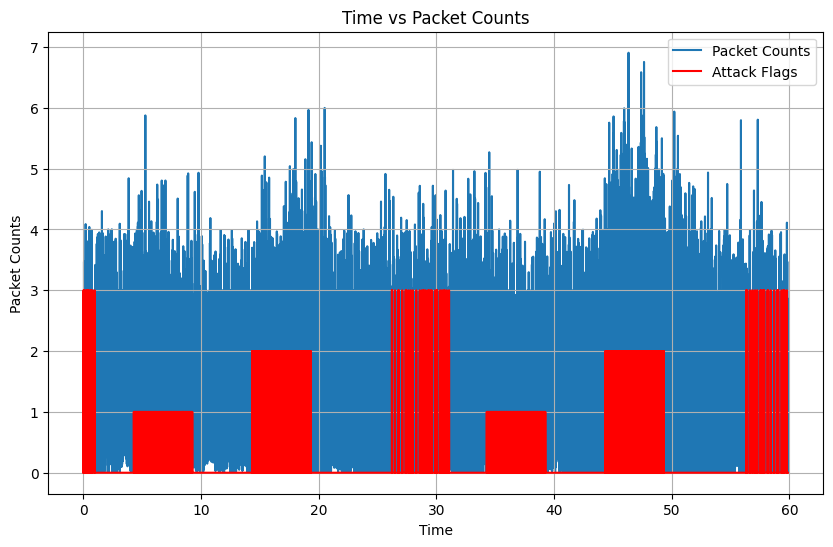

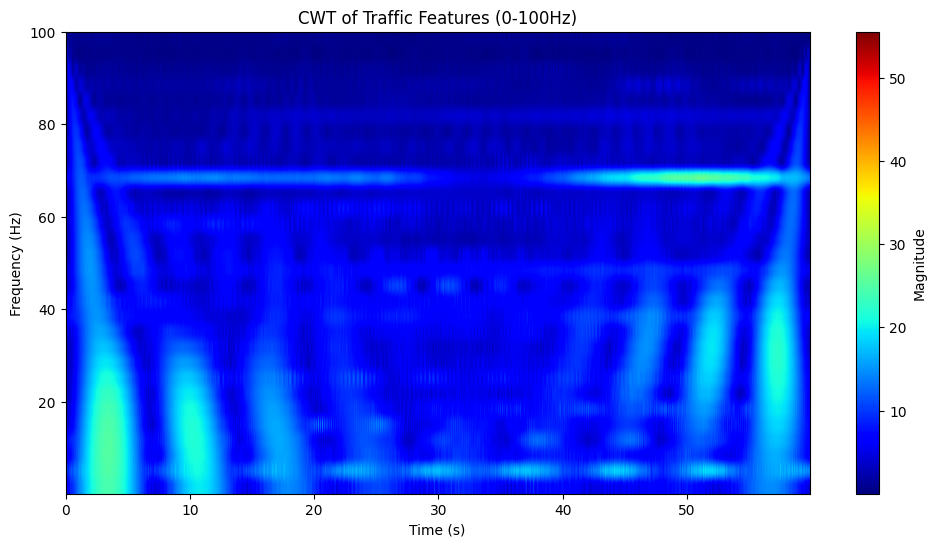

In [53]:
pcap_file = '60smix2.pcapng'
#pcap_file = 'cortag.pcapng'
output_file = 'cwt_traffic_features_0_200hz.png'

# os.system("sudo chmod 777" + pcap_file)
cap = pyshark.FileCapture(pcap_file)

try:
    # 提取流量特征
    time, packet_counts, sample_rate , atk_flags, macro_atkflag = extract_traffic_features(cap, time_window=0.0023)
    
    plot_resized_data(time, packet_counts, None, atk_flags, macro_atkflag)

    coeffs, freqs = perform_cwt(packet_counts, sample_rate, freq_min=0.1, freq_max=100, wavelet='morl', scale_num = 30)
    
    # 绘制并保存图像
    plot_and_save_cwt(coeffs, freqs, time, output_file, title="CWT of Traffic Features (0-100Hz)")
except Exception as e:
    print(f"Error: {e}")


(39916,)
(39916,)


In [4]:
def read_capture(pcap_file):
    pcap_file = '60smix2.pcapng'
    cap = pyshark.FileCapture(pcap_file)

    timestamps = []
    atkflags = []

    # read pcap file to packets
    for packet in cap:
        if 'IP' in packet:  # 只处理包含IP层的包
            timestamps.append(float(packet.sniff_timestamp))
            if 'UDP' in packet:  # 只处理包含UDP层的包
                if hasattr(packet['UDP'], 'payload'):  # 确保存在UDP数据负载
                    udp_payload = packet['UDP'].payload
                    sliced_data = udp_payload[129:131] # atk flag
                    atkflags.append(int(sliced_data, 16))
                    # print("sliced data: ", sliced_data)
                    if sliced_data != '00' and int(sliced_data, 16) > 10:
                        print("related data: ", udp_payload[120:140])
                        # print pack no
                        print("packet no: ", packet.number)
                else:
                    atkflags.append(int('00', 16))
            else:
                atkflags.append(int('00', 16))
    cap.close()

    # 转换为流量时间序列
    timestamps = np.array(timestamps)
    relative_time = timestamps - timestamps[0]  # 转换为相对时间

    atkflags = np.array(atkflags)

    print(atkflags.shape)
    print(relative_time.shape)

    return relative_time, atkflags 

In [11]:
def calculate_packet_count(relative_time ,time_window = 0.01):
    num_buckets = int(np.ceil(relative_time[-1] / time_window))  # 计算时间片的数量
    # 初始化一个列表用于存储每个时间片内的包数量
    packet_counts = np.zeros(num_buckets, dtype=int)

    # 遍历每个包，统计它属于哪个时间片
    for t in relative_time:
        bucket_index = int(t // time_window)  # 计算该包属于哪个时间片
        packet_counts[bucket_index] += 1

    # 计算采样率 (每秒钟包的数量)
    total_time_seconds = relative_time[-1]  # 计算总的相对时间
    total_packets = len(relative_time)  # 总的包数量
    sample_rate = total_packets / total_time_seconds  # 采样率: 每秒钟的包数量

    return packet_counts, sample_rate

In [35]:
def cut_data_by_time(relative_time, atkflags, start_time, end_time):
    # find the index of start time and end time
    start_index = np.where(relative_time >= start_time)[0][0]
    end_index = np.where(relative_time >= end_time)[0][0]

    # cut the data
    relative_time = relative_time[start_index:end_index]
    atkflags = atkflags[start_index:end_index]

    # normalize the time
    relative_time = relative_time - relative_time[0]

    return relative_time, atkflags

In [17]:
pcap_file = '60smix2.pcapng'
relative_time, atkflags = read_capture(pcap_file)
print(relative_time)


(39916,)
(39916,)
[0.00000000e+00 1.98364258e-03 3.30424309e-03 ... 5.98763535e+01
 5.98775887e+01 5.98810966e+01]


In [42]:
start_time = 6
end_time = 8
relative_time1, atkflags1 = cut_data_by_time(relative_time, atkflags, start_time, end_time)
print(relative_time1.shape)
print(atkflags1.shape)

(1269,)
(1269,)


In [58]:
def export_dwt_image(relative_time1, atkflags1, coeffs, freqs, output_path):
    
    macro_atkflag = 0
    for i in range(len(atkflags1)):
        if atkflags1[i] != 0:
            macro_atkflag = atkflags1[i]
            break

    
    print("macro attack flag: ", macro_atkflag)
    print(np.shape(coeffs))
    print(np.shape(freqs))

    plt.figure(figsize=(10, 6))
    plt.imshow(np.abs(coeffs), aspect='auto', extent=[relative_time1[0], relative_time1[-1], freqs[-1], freqs[0]], cmap='jet')


    plt.title("")  
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([])
    plt.yticks([])

    output_file = output_path+ '_' + str(macro_atkflag) + '.png'

    plt.savefig(output_file, dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
    plt.close()


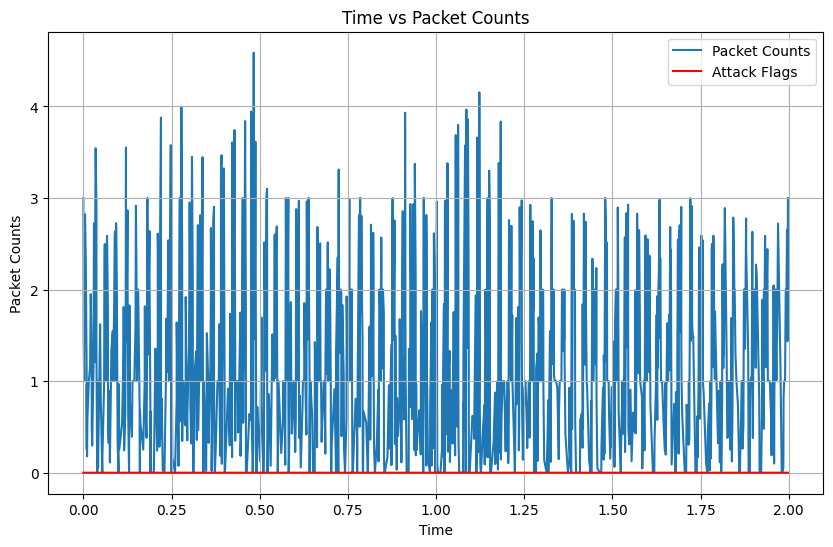

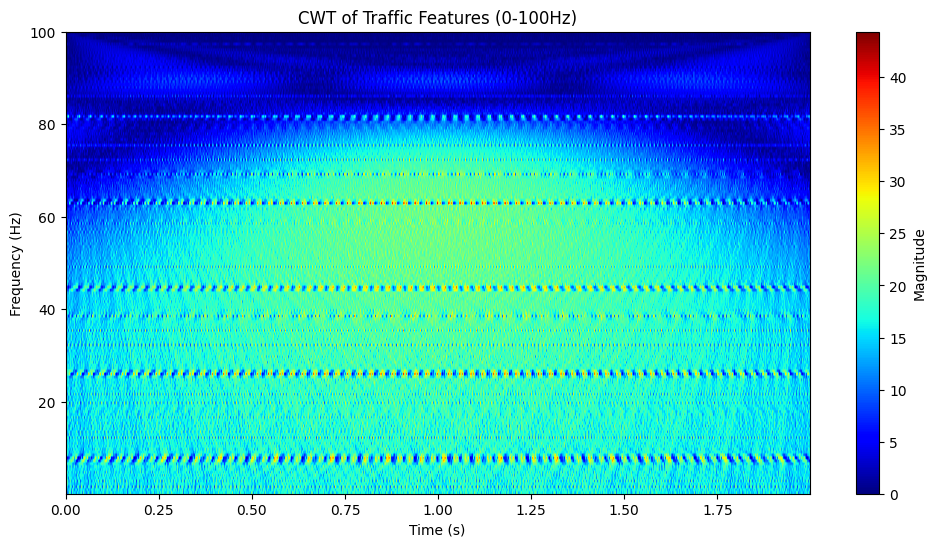

macro attack flag:  0
(160, 999)
(160,)


In [91]:
packet_counts, sample_rate = calculate_packet_count(relative_time1 ,time_window = 0.0020)
plot_resized_data(relative_time1, packet_counts, target_size=None, atk_flags = atkflags1, macro_atkflag = None)
coeffs, freqs = perform_cwt(packet_counts, sample_rate, freq_min=0.1, freq_max=100, wavelet='morl', scale_num = 160)
plot_and_save_cwt(coeffs, freqs, relative_time1, None, title="CWT of Traffic Features (0-100Hz)")

# go through all the attack flags, if any not 0 attack flag, let macro attack flag = that attack flag
macro_atkflag = 0
for i in range(len(atkflags1)):
    if atkflags1[i] != 0:
        macro_atkflag = atkflags1[i]
        break

output_file = 'cwt_image2.png'
export_dwt_image(relative_time1, atkflags1, coeffs, freqs, output_file)




make around 480 data

In [41]:
# pcap_file = '60smix2.pcapng'
# relative_time, atkflags = read_capture(pcap_file)

time_interval = (58 - 1) / 600

for i in range(0, 600):
    start_time = 1 + i * time_interval
    end_time = start_time + 2
    print(start_time, end_time)
    # relative_time1, atkflags1 = cut_data_by_time(relative_time, atkflags, start_time, end_time)
    # packet_counts, sample_rate = calculate_packet_count(relative_time1 ,time_window = 0.01)
    # plot_resized_data(relative_time1, packet_counts, target_size=None, atk_flags = atkflags1, macro_atkflag = None)
    # coeffs, freqs = perform_cwt(packet_counts, sample_rate, freq_min=0.1, freq_max=100, wavelet='morl', scale_num = 30)
    # plot_and_save_cwt(coeffs, freqs, relative_time1, None, title="CWT of Traffic Features (0-100Hz)")

1.0 3.0
1.095 3.0949999999999998
1.19 3.19
1.2850000000000001 3.285
1.38 3.38
1.475 3.475
1.57 3.5700000000000003
1.665 3.665
1.76 3.76
1.855 3.855
1.95 3.95
2.045 4.045
2.14 4.140000000000001
2.2350000000000003 4.235
2.33 4.33
2.425 4.425
2.52 4.52
2.615 4.615
2.71 4.71
2.8049999999999997 4.805
2.9 4.9
2.995 4.995
3.09 5.09
3.185 5.1850000000000005
3.2800000000000002 5.28
3.375 5.375
3.47 5.470000000000001
3.565 5.5649999999999995
3.66 5.66
3.755 5.755
3.85 5.85
3.945 5.945
4.04 6.04
4.135 6.135
4.23 6.23
4.325 6.325
4.42 6.42
4.515000000000001 6.515000000000001
4.609999999999999 6.609999999999999
4.705 6.705
4.8 6.8
4.895 6.895
4.99 6.99
5.085 7.085
5.18 7.18
5.275 7.275
5.37 7.37
5.465 7.465
5.5600000000000005 7.5600000000000005
5.655 7.655
5.75 7.75
5.845 7.845
5.94 7.94
6.035 8.035
6.13 8.129999999999999
6.225 8.225
6.32 8.32
6.415 8.415
6.51 8.51
6.605 8.605
6.7 8.7
6.795 8.795
6.89 8.89
6.985 8.985
7.08 9.08
7.175 9.175
7.2700000000000005 9.27
7.365 9.365
7.46 9.46
7.555 9.555
7

In [92]:
pcap_file = '60smix2.pcapng'
relative_time, atkflags = read_capture(pcap_file)



(39916,)
(39916,)
macro attack flag:  0
(160, 1000)
(160,)
macro attack flag:  1
(160, 999)
(160,)
macro attack flag:  2
(160, 999)
(160,)
macro attack flag:  2
(160, 999)
(160,)
macro attack flag:  0
(160, 1000)
(160,)
macro attack flag:  3
(160, 999)
(160,)
macro attack flag:  1
(160, 999)
(160,)
macro attack flag:  0
(160, 997)
(160,)
macro attack flag:  2
(160, 1000)
(160,)
macro attack flag:  0
(160, 999)
(160,)


In [102]:
sample_number = 6

time_interval = (58 - 1) / sample_number

# clear the files in cwt_images folder
os.system("rm -rf cwt_images/*")

for i in range(0, sample_number):
    start_time = 1 + i * time_interval
    end_time = start_time + 2
    
    relative_time1, atkflags1 = cut_data_by_time(relative_time, atkflags, start_time, end_time)
    packet_counts, sample_rate = calculate_packet_count(relative_time1 ,time_window = 0.001)
    # plot_resized_data(relative_time1, packet_counts, target_size=None, atk_flags = atkflags1, macro_atkflag = None)
    coeffs, freqs = perform_cwt(packet_counts, sample_rate, freq_min=0.1, freq_max=100, wavelet='morl', scale_num = 200)
    output_path = 'cwt_images/' + str(i)
    export_dwt_image(relative_time1, atkflags1, coeffs, freqs, output_path)
    # plot_and_save_cwt(coeffs, freqs, relative_time1, None, title="CWT of Traffic Features (0-100Hz)")

macro attack flag:  0
(200, 2000)
(200,)
macro attack flag:  0
(200, 1999)
(200,)
macro attack flag:  0
(200, 1999)
(200,)
macro attack flag:  3
(200, 1997)
(200,)
macro attack flag:  1
(200, 1999)
(200,)
macro attack flag:  2
(200, 1998)
(200,)
